In [16]:
import os
import cv2
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models


In [17]:
# Define paths
image_path = r"C:\Users\aryan\Desktop\ShanghaiTech\part_A\train_data\images"
label_path = r"C:\Users\aryan\Desktop\ShanghaiTech\part_A\train_data\ground-truth"


In [18]:
# Function to load images and annotations
def load_data(image_path, label_path, sample_index=0):
    # List image files
    image_files = sorted([f for f in os.listdir(image_path) if f.endswith('.jpg')])
    label_files = sorted([f for f in os.listdir(label_path) if f.endswith('.mat')])
    
    # Load a sample image and corresponding label
    sample_image_file = image_files[110]
    sample_label_file = label_files[110]
    
    # Load image
    image = cv2.imread(os.path.join(image_path, sample_image_file))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load label (ground-truth points)
    label_data = sio.loadmat(os.path.join(label_path, sample_label_file))
    points = label_data["image_info"][0,0][0,0][0]  # Adjust according to .mat structure

    return image, points


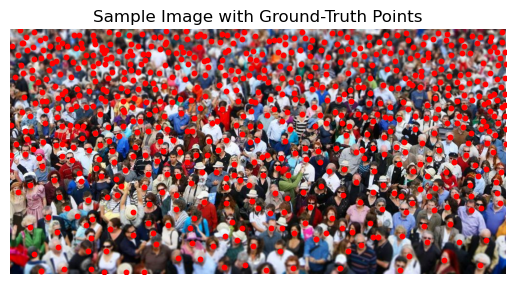

In [19]:
# Load a sample image and display it with ground-truth points
image, points = load_data(image_path, label_path, sample_index=0)

plt.imshow(image)
plt.scatter(points[:, 0], points[:, 1], s=10, color='red')  # Plot points on image
plt.title("Sample Image with Ground-Truth Points")
plt.axis('off')
plt.show()


In [20]:
def create_density_map(image_shape, points):
    density_map = np.zeros(image_shape[:2], dtype=np.float32)
    
    # Apply a Gaussian filter on each point
    for point in points:
        x, y = min(int(point[0]), image_shape[1] - 1), min(int(point[1]), image_shape[0] - 1)
        density_map[y, x] = 1

    density_map = cv2.GaussianBlur(density_map, (15, 15), 0)
    return density_map


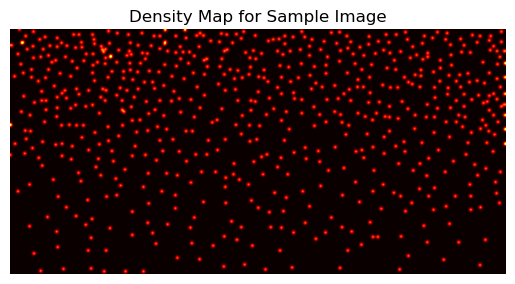

In [21]:
# Create and display density map for the sample image
density_map = create_density_map(image.shape, points)

plt.imshow(density_map, cmap='hot')
plt.axis('off')
plt.title("Density Map for Sample Image")
plt.show()


In [8]:
## CSRNET

In [9]:
!pip install tensorflow matplotlib h5py scipy


In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.io import loadmat
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import random


C:\Users\aryan\AppData\Local\Temp\ipykernel_8332\3840860461.py:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [11]:
# Define paths
image_dir = r"C:\Users\aryan\Desktop\ShanghaiTech\part_A\train_data\images"
label_dir = r"C:\Users\aryan\Desktop\ShanghaiTech\part_A\train_data\ground-truth"


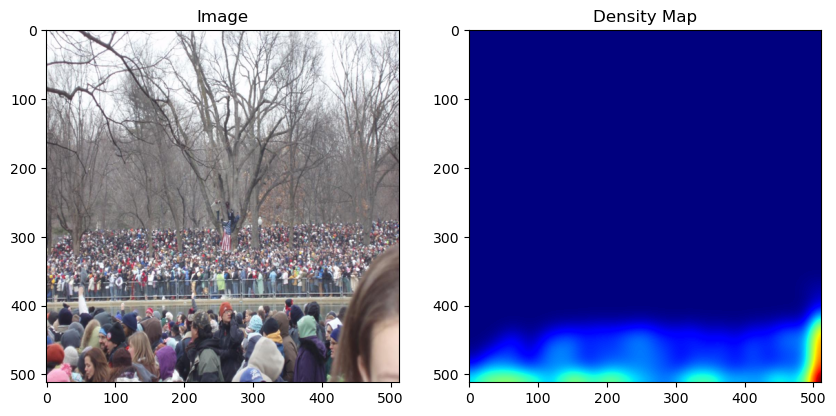

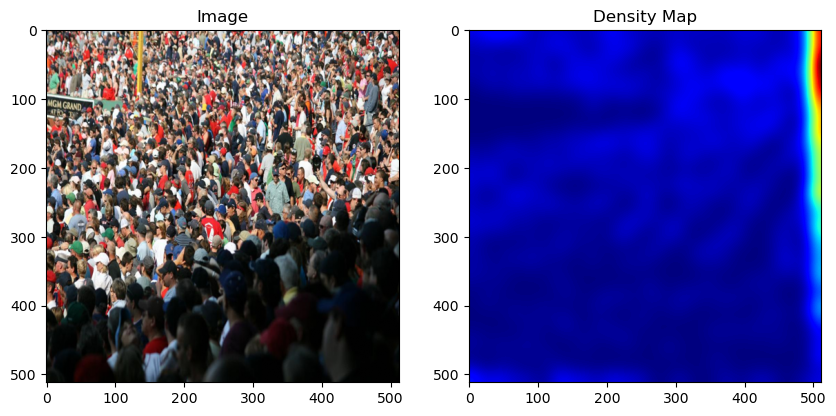

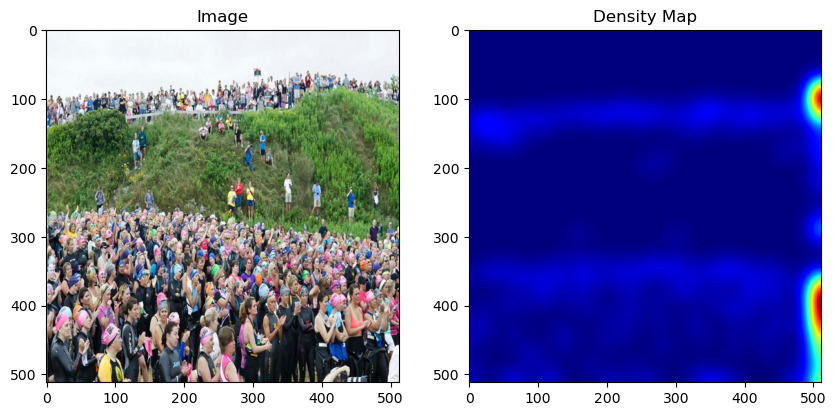

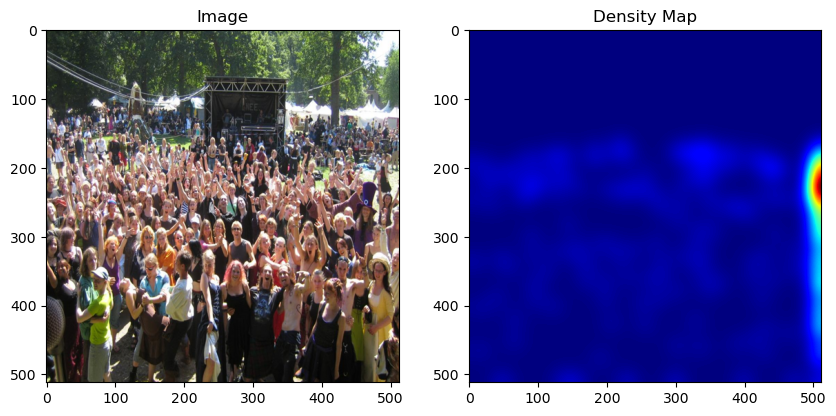

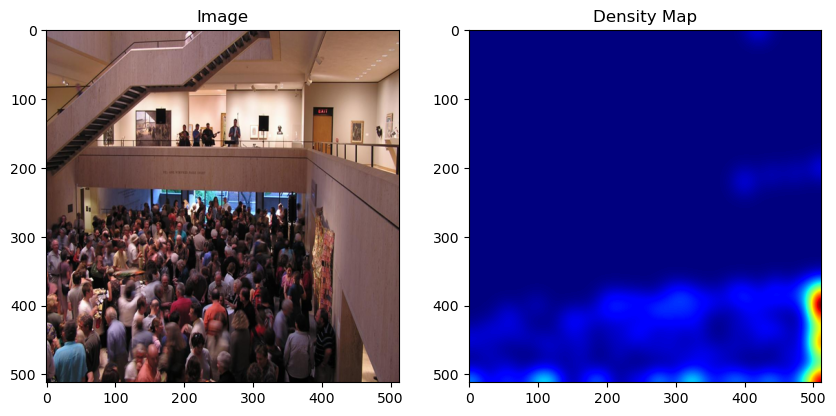

In [12]:
def preprocess_image_and_density_map(img_path, label_path, target_size=(512, 512)):
    # Load and resize image
    image = Image.open(img_path).convert('RGB')
    image = image.resize(target_size)
    image = np.array(image) / 255.0  # Normalize to [0, 1]

    # Load .mat file and create density map
    ann_points = loadmat(label_path)['image_info'][0][0][0][0][0]
    density_map = np.zeros(target_size, dtype=np.float32)

    # Generate density map from annotated points
    for point in ann_points:
        x, y = min(int(point[0] * target_size[1] / image.shape[1]), target_size[1] - 1), \
               min(int(point[1] * target_size[0] / image.shape[0]), target_size[0] - 1)
        density_map[y, x] = 1
    
    density_map = gaussian_filter(density_map, sigma=15)  # Apply Gaussian filter

    return image, density_map

# Load and preprocess a sample image and density map to check
sample_images = os.listdir(image_dir)[:5]  # Load a few sample images
for img_name in sample_images:
    img_path = os.path.join(image_dir, img_name)
    label_path = os.path.join(label_dir, f"GT_{img_name.split('.')[0]}.mat")
    img, density_map = preprocess_image_and_density_map(img_path, label_path)

    # Display the image and density map
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.subplot(1, 2, 2)
    plt.imshow(density_map, cmap='jet')
    plt.title("Density Map")
    plt.show()


## MAIN

In [1]:
import os
import cv2
import numpy as np
import scipy.io as sio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from glob import glob


In [2]:
# Define paths
image_path = r"C:\Users\aryan\Desktop\ShanghaiTech\part_A\train_data\images"
label_path = r"C:\Users\aryan\Desktop\ShanghaiTech\part_A\train_data\ground-truth"


In [5]:
# Helper function to load and preprocess images
def load_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))  # Resize to reduce computational load
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    return img

# Helper function to load and preprocess density maps
def load_density_map(gt_path):
    mat = sio.loadmat(gt_path)
    density_map = mat["image_info"][0, 0][0, 0][0]  # Adjust indexing if necessary
    density_map = cv2.resize(density_map, (128, 128))
    density_map = np.expand_dims(density_map, axis=-1)
    return density_map


In [6]:
def load_data(image_path, label_path):
    images = []
    density_maps = []
    image_files = sorted(glob(os.path.join(image_path, "*.jpg")))
    label_files = sorted(glob(os.path.join(label_path, "GT_IMG_*.mat")))
    
    for img_file, lbl_file in zip(image_files, label_files):
        img = load_image(img_file)
        density_map = load_density_map(lbl_file)
        
        images.append(img)
        density_maps.append(density_map)
    
    images = np.array(images, dtype=np.float32)
    density_maps = np.array(density_maps, dtype=np.float32)
    
    return images, density_maps

# Load the dataset
X_train, y_train = load_data(image_path, label_path)


In [12]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(1, (1, 1), activation='linear', padding='same'))  # Output layer for density map
    return model

# Instantiate the model
model = build_model()


In [13]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')  # Mean Squared Error for density map regression


In [14]:
# Checkpoint callback to save the best model
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True, verbose=1)


In [16]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=8,
    validation_split=0.2,
    callbacks=[checkpoint]
)


Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 159705.4688
Epoch 1: val_loss improved from inf to 173098.01562, saving model to best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 195s 7s/step - loss: 159671.5312 - val_loss: 173098.0156
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 157914.5156
Epoch 2: val_loss improved from 173098.01562 to 147299.45312, saving model to best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 210s 7s/step - loss: 157655.5000 - val_loss: 147299.4531
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 123501.7812
Epoch 3: val_loss improved from 147299.45312 to 66834.25000, saving model to best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 244s 8s/step - loss: 122673.6250 - val_loss: 66834.2500
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 59365.4453
Epoch 4: val_loss improved from 66834.25000 to 62819.46094, saving model to best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 235s 8s/step - loss: 59410.2930 - val_loss: 62819.4609
Epoch 5/5
30/30 ━━━━━━━━━━━━

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import scipy.io as sio
import os


In [23]:
# Paths to test images and labels
test_image_path = r"C:\Users\aryan\Desktop\ShanghaiTech\part_A\test_data\images"
test_label_path = r"C:\Users\aryan\Desktop\ShanghaiTech\part_A\test_data\ground-truth"


In [24]:
def load_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    return img

def load_density_map(gt_path):
    mat = sio.loadmat(gt_path)
    density_map = mat["image_info"][0, 0][0, 0][0]
    density_map = cv2.resize(density_map, (128, 128))
    density_map = np.expand_dims(density_map, axis=-1)
    return density_map


In [25]:
# Load the trained model
model = load_model("best_model.keras")


In [26]:
# Test on a single image
test_image_file = os.path.join(test_image_path, "IMG_1.jpg")  # Replace with a test image file name
test_label_file = os.path.join(test_label_path, "GT_IMG_1.mat")  # Corresponding ground truth file

# Load and preprocess the image and ground truth density map
test_image = load_image(test_image_file)
test_density_map = load_density_map(test_label_file)

# Predict the density map
predicted_density_map = model.predict(np.expand_dims(test_image, axis=0))[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


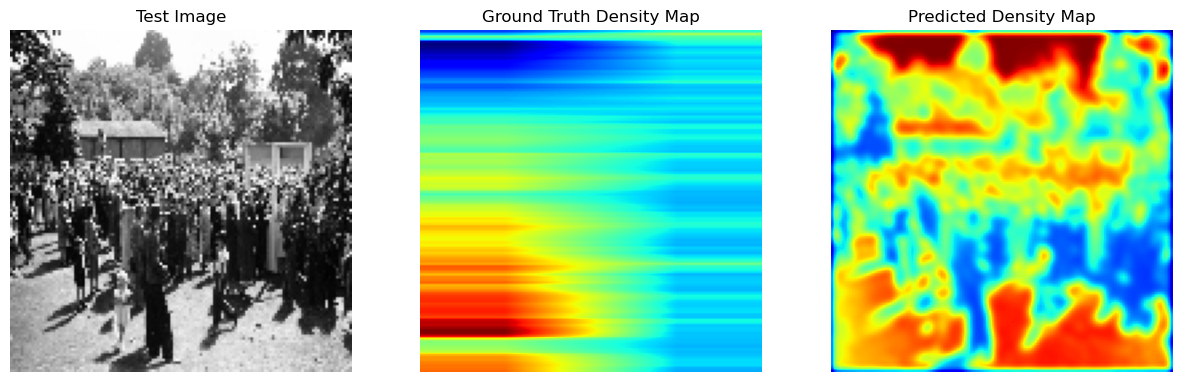

In [27]:
# Plot test image, ground truth, and predicted density map
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(test_image.squeeze(), cmap='gray')
plt.title("Test Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(test_density_map.squeeze(), cmap='jet')
plt.title("Ground Truth Density Map")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(predicted_density_map.squeeze(), cmap='jet')
plt.title("Predicted Density Map")
plt.axis("off")

plt.show()


In [28]:
# Estimate people count from predicted density map
predicted_count = np.sum(predicted_density_map)
print(f"Predicted People Count: {predicted_count:.2f}")

# Actual people count from ground truth density map
actual_count = np.sum(test_density_map)
print(f"Actual People Count: {actual_count:.2f}")


Predicted People Count: 5924470.00
Actual People Count: 6488879.76


In [29]:
# Initialize lists to store predicted and actual counts
predicted_counts = []
actual_counts = []

# Get test images and corresponding ground truth files
test_image_files = sorted(glob(os.path.join(test_image_path, "*.jpg")))
test_label_files = sorted(glob(os.path.join(test_label_path, "GT_IMG_*.mat")))

# Loop through the test set
for img_file, lbl_file in zip(test_image_files, test_label_files):
    # Load and preprocess the image and density map
    img = load_image(img_file)
    density_map = load_density_map(lbl_file)
    
    # Predict the density map
    pred_density_map = model.predict(np.expand_dims(img, axis=0))[0]
    
    # Calculate total people count
    predicted_count = np.sum(pred_density_map)
    actual_count = np.sum(density_map)
    
    # Append counts to lists
    predicted_counts.append(predicted_count)
    actual_counts.append(actual_count)

# Calculate Mean Absolute Error (MAE) and Mean Squared Error (MSE)
predicted_counts = np.array(predicted_counts)
actual_counts = np.array(actual_counts)
mae = np.mean(np.abs(predicted_counts - actual_counts))
mse = np.mean((predicted_counts - actual_counts) ** 2)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


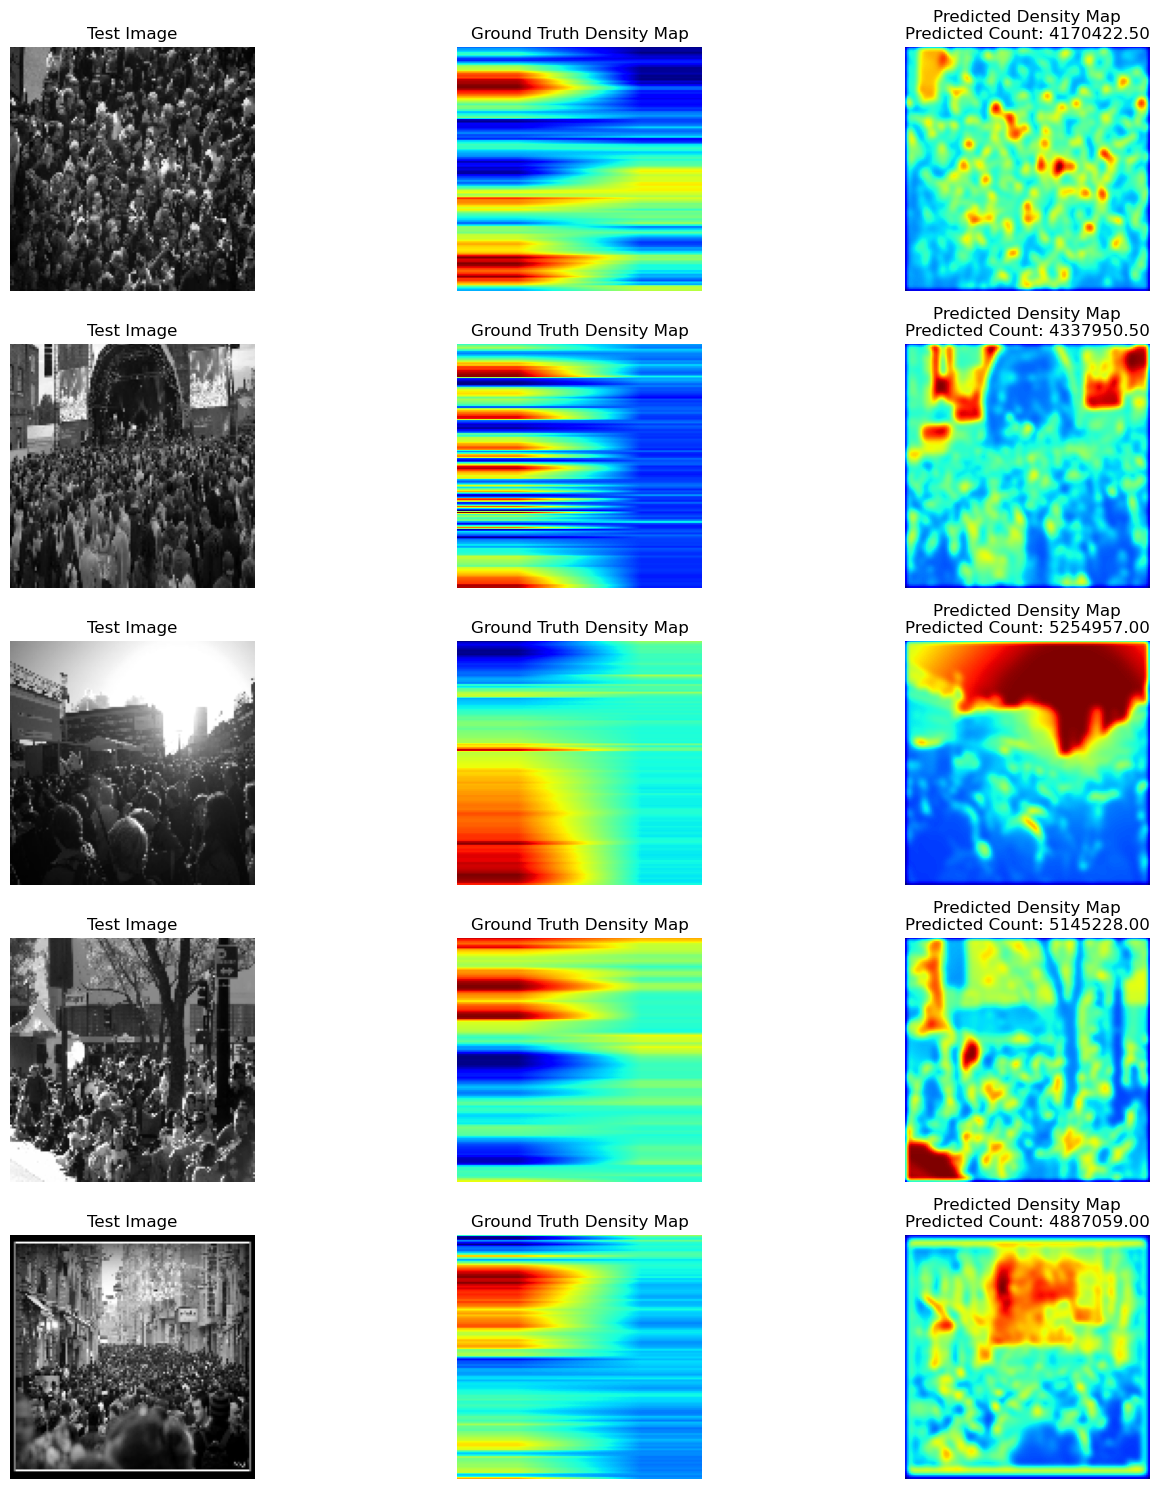

In [30]:
# Visualize a few predictions
num_samples = 5  # Number of samples to display
sample_indices = np.random.choice(len(test_image_files), num_samples, replace=False)

plt.figure(figsize=(15, 3 * num_samples))

for i, idx in enumerate(sample_indices):
    # Load the image and density map
    img = load_image(test_image_files[idx])
    density_map = load_density_map(test_label_files[idx])
    
    # Predict the density map
    pred_density_map = model.predict(np.expand_dims(img, axis=0))[0]
    
    # Plot the results
    plt.subplot(num_samples, 3, 3 * i + 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title("Test Image")
    plt.axis("off")
    
    plt.subplot(num_samples, 3, 3 * i + 2)
    plt.imshow(density_map.squeeze(), cmap='jet')
    plt.title("Ground Truth Density Map")
    plt.axis("off")
    
    plt.subplot(num_samples, 3, 3 * i + 3)
    plt.imshow(pred_density_map.squeeze(), cmap='jet')
    plt.title(f"Predicted Density Map\nPredicted Count: {np.sum(pred_density_map):.2f}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [31]:
# Verify the sum of density maps in the ground truth
for lbl_file in test_label_files[:5]:  # Check the first 5 files
    density_map = load_density_map(lbl_file)
    print(f"Actual count from density map: {np.sum(density_map):.2f}")


Actual count from density map: 6488879.76
Actual count from density map: 6361266.54
Actual count from density map: 5029885.74
Actual count from density map: 6646814.06
Actual count from density map: 2657031.97


In [32]:
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_loss(y_true, y_pred):
    # Focus on the difference in total counts
    return K.mean(K.square(K.sum(y_pred) - K.sum(y_true)))

model.compile(optimizer='adam', loss=custom_loss)


In [1]:
## YOLO v8

In [8]:
!pip install opencv-python-headless opencv-contrib-python --user

  Obtaining dependency information for opencv-contrib-python from https://files.pythonhosted.org/packages/a7/9e/7110d2c5d543ab03b9581dbb1f8e2429863e44e0c9b4960b766f230c1279/opencv_contrib_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata
  Using cached opencv_contrib_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_contrib_python-4.10.0.84-cp37-abi3-win_amd64.whl (45.5 MB)


In [3]:
!pip install -r yolov5/requirements.txt

In [4]:
!pip install opencv-python-headless ultralytics pillow


In [5]:
# Import necessary libraries
import os
import cv2
import torch
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
from ultralytics import YOLO
import numpy as np


In [6]:
# Load YOLOv8 model
model = YOLO("yolov8n.pt")  # Replace with the path to your YOLOv8 model file if necessary


In [7]:
# Define the Tkinter GUI with video upload and display functionality
class VideoApp:
    def __init__(self, root):
        self.root = root
        self.root.title("YOLOv8 Object Detection")

        # Video display panel
        self.panel = tk.Label(root)
        self.panel.pack(padx=10, pady=10)

        # Upload Button
        upload_btn = tk.Button(root, text="Upload Video", command=self.upload_video)
        upload_btn.pack(side="bottom", padx=10, pady=10)

    def upload_video(self):
        video_path = filedialog.askopenfilename(title="Select Video File", filetypes=[("MP4 files", "*.mp4")])
        if video_path:
            self.process_video(video_path)

    def process_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Perform YOLOv8 detection
            results = model(frame)
            detections = results[0].boxes  # Access the detected boxes directly

            # Draw boxes and labels on detected objects
            for detection in detections:
                x1, y1, x2, y2 = map(int, detection.xyxy[0][:4])  # Get bounding box coordinates
                conf = float(detection.conf[0])
                cls = int(detection.cls[0])
                label = model.names[cls]
                
                if label == "person":  # Only track "person" objects
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(frame, f"{label} {conf:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            
            # Convert and display frame on Tkinter panel
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img_pil = Image.fromarray(frame_rgb)
            img_tk = ImageTk.PhotoImage(img_pil)
            self.panel.imgtk = img_tk
            self.panel.configure(image=img_tk)
            self.root.update_idletasks()
            self.root.update()

        cap.release()
        messagebox.showinfo("Info", "Video processing complete")


In [9]:
# Initialize Tkinter root and start VideoApp
if __name__ == "__main__":
    root = tk.Tk()
    app = VideoApp(root)
    root.mainloop()



0: 384x640 11 persons, 1 bench, 1 umbrella, 292.2ms
Speed: 20.0ms preprocess, 292.2ms inference, 19.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 bench, 1 umbrella, 187.0ms
Speed: 7.0ms preprocess, 187.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 bench, 1 umbrella, 225.0ms
Speed: 5.0ms preprocess, 225.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 umbrella, 220.0ms
Speed: 8.0ms preprocess, 220.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 2 benchs, 1 umbrella, 232.2ms
Speed: 4.0ms preprocess, 232.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 umbrella, 204.0ms
Speed: 4.0ms preprocess, 204.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 backpack, 1 umbrella, 183.8ms
Speed: 8.0ms preprocess, 183.8ms inference, 2.0ms pos

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\aryan\anaconda3\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\aryan\AppData\Local\Temp\ipykernel_12648\1179196086.py", line 18, in upload_video
    self.process_video(video_path)
  File "C:\Users\aryan\AppData\Local\Temp\ipykernel_12648\1179196086.py", line 45, in process_video
    img_tk = ImageTk.PhotoImage(img_pil)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aryan\anaconda3\Lib\site-packages\PIL\ImageTk.py", line 128, in __init__
    self.__photo = tkinter.PhotoImage(**kw)
                   ^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aryan\anaconda3\Lib\tkinter\__init__.py", line 4125, in __init__
    Image.__init__(self, 'photo', name, cnf, master, **kw)
  File "C:\Users\aryan\anaconda3\Lib\tkinter\__init__.py", line 4062, in __init__
    master = _get_default_root('create image')
             ^^^^^^^^^^^^^^^^^^^^